In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from pandas import rolling_median
from math import pi
from scipy import signal
import os

In [57]:
def findCondIndex(arr, cond):
    for i, yi in enumerate(reversed(list(arr))):
        lent = len(arr)
        if cond(yi):
            break
    return lent - i - 1

# Читаем спектр образца из файла

In [58]:
#read data from file
pathway='/Users/dariasatco/Documents/study/research_project/experiment/02032018_seva/cnt_seva_2V.Sample.csv'

string = pathway.split('/')
name = string.pop()
dirname = '/'.join(string)+'/'+'results'
# print(name,dirname)
if not os.path.exists(dirname):
    os.makedirs(dirname)

dataOCP=pd.read_csv(pathway, names=('wavelength','absorbance'),sep=';')
dataOCP.drop(dataOCP.index[:2], inplace=True)
#dataOCP.info() #control output
#print(dataOCP)
dataOCP=dataOCP.astype(float) #convert object to float type
#dataOCP.dtypes
number_len=len((dataOCP.index))+2
#dataOCP.index

# Убираем ступеньки из спектра

In [59]:
n1=dataOCP.loc[dataOCP['wavelength'] == 1800.0].index.values[0]
n2=dataOCP.loc[dataOCP['wavelength'] == 860.0].index.values[0]

dataOCP.loc[n2:,'step free']=dataOCP.loc[n2:,'absorbance']
dataOCP.loc[n1:n2-1, 'step free']=dataOCP.loc[n1:n2-1,'absorbance']+(dataOCP.loc[n2,'absorbance']-\
         dataOCP.loc[n2-1,'absorbance'])
dataOCP.loc[:n1-1,'step free']=dataOCP.loc[:n1-1,'absorbance']+(dataOCP.loc[n2,'absorbance']-\
         dataOCP.loc[n2-1,'absorbance']+dataOCP.loc[n1,'absorbance']-dataOCP.loc[n1-1,'absorbance'])
#dataOCP.info()

In [60]:
#try to remove noise

dataOCP['rol_mean'] = dataOCP['step free'].rolling(window=3,center=True).median()
difference = np.abs(dataOCP['step free'] - dataOCP['rol_mean'])
outlier_idx = difference > 0.01
dataOCP.loc[outlier_idx, 'step free']=dataOCP.loc[outlier_idx, 'rol_mean']
#dataOCP.info()

In [61]:
h=4.135667e-15 #Planck constant
cv=299792458 #speed of light
nano=1e-9 #nano scaling
dataOCP['energy']=h*cv/(dataOCP['wavelength']*nano)
#dataOCP.info()
#dataOCP

# Спектр до вычета ионной жидкости

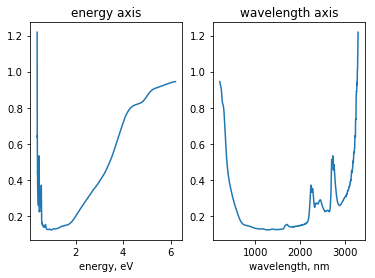

In [62]:
%matplotlib inline
plt.subplot(1, 2, 1)
plt.plot(dataOCP['energy'],dataOCP['step free'])
plt.title('energy axis')
plt.xlabel('energy, eV')

plt.subplot(1, 2, 2)
plt.plot(dataOCP['wavelength'],dataOCP['step free'])
plt.title('wavelength axis')
plt.xlabel('wavelength, nm')

plt.show()

# Читаем данные ионной жидкости

In [63]:
pathway='/Users/dariasatco/Documents/study/research_project/experiment/02032018_seva/IL_deme.Sample.csv'
dataIL=pd.read_csv(pathway, names=('wavelength','absorbance'),sep=';')
dataIL.drop(dataIL.index[:2], inplace=True)
#dataIL.info() #control output
dataIL=dataIL.astype(float) #convert object to float type
#dataIL.dtypes

In [64]:
#убираем ступеньку
dataIL.loc[n2:,'step free']=dataIL.loc[n2:,'absorbance']
dataIL.loc[n1:n2-1, 'step free']=dataIL.loc[n1:n2-1,'absorbance']+dataIL.loc[n2,'absorbance']-\
         dataIL.loc[n2-1,'absorbance']
dataIL.loc[:n1-1,'step free']=dataIL.loc[:n1-1,'absorbance']+dataIL.loc[n2,'absorbance']-\
         dataIL.loc[n2-1,'absorbance']+dataIL.loc[n1,'absorbance']-dataIL.loc[n1-1,'absorbance']
#dataIL.info()

In [65]:
#energy
dataIL['energy']=h*cv/(dataIL['wavelength']*nano)

# Спектр ионной жидкости 

In [66]:
#try to remove noise

dataIL['rol_mean'] = dataIL['step free'].rolling(window=3,center=True).median()
difference = np.abs(dataIL['step free'] - dataIL['rol_mean'])
outlier_idx = difference > 0.01
dataIL.loc[outlier_idx, 'step free']=dataIL.loc[outlier_idx, 'rol_mean']
#dataIL.info()

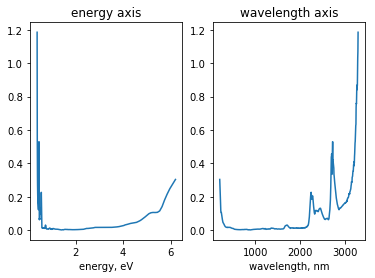

In [67]:
%matplotlib inline
plt.subplot(1, 2, 1)
plt.plot(dataIL['energy'],dataIL['step free'])
plt.title('energy axis')
plt.xlabel('energy, eV')

plt.subplot(1, 2, 2)
plt.plot(dataIL['wavelength'],dataIL['step free'])
plt.title('wavelength axis')
plt.xlabel('wavelength, nm')

plt.show()

# Вычитаем ионную жидкость из спектра образца

In [68]:
dataOCP['data-IL']=dataOCP['step free']-dataIL['step free']
#dataOCP.info()

In [43]:
#try to remove noise

dataOCP['rol_mean1'] = dataOCP['data-IL'].rolling(window=3,center=True).median()
difference = np.abs(dataOCP['data-IL'] - dataOCP['rol_mean1'])
outlier_idx = difference > 0.1
dataOCP.loc[outlier_idx, 'data-IL']=dataOCP.loc[outlier_idx, 'rol_mean1']
noise_num = findCondIndex(np.array(dataOCP['data-IL']), lambda x: x < 0.0)+2
#print(noise_num)
dataOCP.loc[:noise_num, 'data-IL']=np.mean(dataOCP.loc[:noise_num,'data-IL'])*np.ones(noise_num-1)

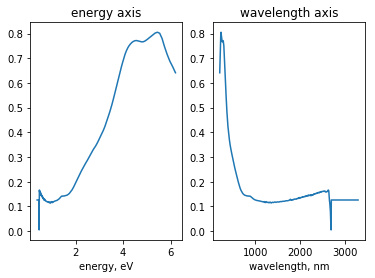

In [45]:
%matplotlib inline
plt.subplot(1, 2, 1)
plt.plot(dataOCP['energy'],dataOCP['data-IL'])
plt.title('energy axis')
plt.xlabel('energy, eV')

plt.subplot(1, 2, 2)
plt.plot(dataOCP['wavelength'],dataOCP['data-IL'])
plt.title('wavelength axis')
plt.xlabel('wavelength, nm')

plt.show()

# Ищем background

Lorentz-Fano parameters:
center = 5.56673542296
gammaL = 1.16392883037
numL = 2.73923134703
resonance = 4.32572717024
gammaF = 1.66711766044
q = -4.11317597841
numF = 0.024604304576


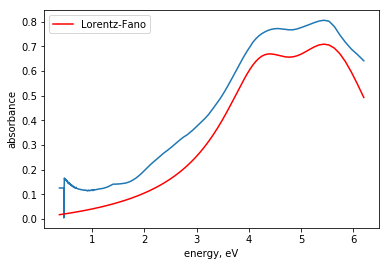

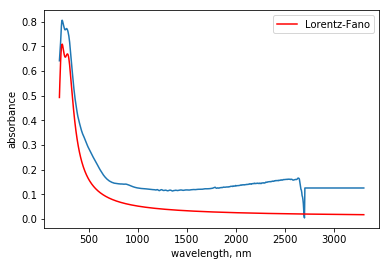

In [47]:
# Lorentz-Fano model
def LorentzFano(x, center,gammaL,numL, resonance,gammaF,q,numF):
    return numL/(pi*gammaL*(1.0+((x-center)/gammaL)**2)) + \
    (2*(x-resonance)/gammaF + q)**2/((2*(x-resonance)/gammaF)**2 + 1.0)*numF
    
# Lorentz-Lorentz-Fano model
def L_LorentzFano(x, center1,gammaL1,numL1, center2,gammaL2,numL2, resonance,gammaF,q,numF):
    return numL1/(pi*gammaL1*(1.0+((x-center1)/gammaL1)**2)) + \
    numL2/(pi*gammaL2*(1.0+((x-center2)/gammaL2)**2)) + \
    (2*(x-resonance)/gammaF + q)**2/((2*(x-resonance)/gammaF)**2 + 1.0)*numF

# Double_Lorentz
def Double_Lorentz(x, center,gammaL,numL, center1,gammaL1,numL1):
    return numL/(pi*gammaL*(1.0+((x-center)/gammaL)**2)) + numL1/(pi*gammaL1*(1.0+((x-center1)/gammaL1)**2))
    
# Lorentz model
def Lorentz(x, center,gammaL,numL):
    return numL/(pi*gammaL*(1.0+((x-center)/gammaL)**2))

#Fano model
def Fano(x, resonance,gammaF,q,numF):
    return numF*(2*(x-resonance)/gammaF + q)**2/((2*(x-resonance)/gammaF)**2 + 1.0)

def makePenFuntion(y):
    #Function with constraint
    def LF_constraints(x, center,gammaL,numL, resonance,gammaF,q,numF):
        #print(type(x))
        diff = 0.0
        lst = []
        for arg, val in zip(x,y):
            model = LorentzFano(arg, center,gammaL,numL, resonance,gammaF,q,numF)
            resid = model - val
            if resid > 0:
                model += 100*resid #Penalty
            lst.append(model)
        return np.array(lst)
    return LF_constraints

def makePenFuntion_LLF(y):
    #Function with constraint
    def LLF_constraints(x, center1,gammaL1,numL1, center2,gammaL2,numL2, resonance,gammaF,q,numF):
        #print(type(x))
        diff = 0.0
        lst = []
        for arg, val in zip(x,y):
            model = L_LorentzFano(arg, center1,gammaL1,numL1, center2,gammaL2,numL2, resonance,gammaF,q,numF)
            resid = model - val
            if resid > 0:
                model += 100*resid #Penalty
            lst.append(model)
        return np.array(lst)
    return LLF_constraints

minparam=(4,0.1,0, 3,0.1,-10,0.005) #lower bound for approximation parameters
maxparam=(6,4,10, 5.3,4,0,1)         #upper bound for approximation parameters
initial=(5,0.2,1, 4,0.1,-5,0.01)

initial1=(4,0.2,1, 5,0.2,1, 4,0.1,-5,0.01)
minparam1=(4,0.1,0, 3,0.1,0, 3,0.1,-10,0.005) #lower bound for approximation parameters
maxparam1=(6,4,10, 6,4,10, 5,4,0,2)         #upper bound for approximation parameters

x=np.array(dataOCP['energy'])        
y=np.array(dataOCP['data-IL'])

#LFopt, LFcov = curve_fit(makePenFuntion(y), x, y, initial, bounds=(minparam,maxparam), method='trf')
LFopt, LFcov = curve_fit(LorentzFano, x, y, initial, bounds=(minparam,maxparam), method='trf')
#LLFopt, LLFcov = curve_fit(makePenFuntion_LLF(y), x, y, initial1, bounds=(minparam1,maxparam1), method='trf')

print('Lorentz-Fano parameters:')
print('center =', LFopt[0])
print('gammaL =', LFopt[1])
print('numL =', LFopt[2])
print('resonance =', LFopt[3])
print('gammaF =', LFopt[4])
print('q =', LFopt[5])
print('numF =', LFopt[6])

#print('Lor-Lorentz-Fano parameters:')
#print('center1 =', LLFopt[0])
#print('gammaL1 =', LLFopt[1])
#print('numL1 =', LLFopt[2])
#print('center2 =', LLFopt[3])
#print('gammaL2 =', LLFopt[4])
#print('numL2 =', LLFopt[5])
#print('resonance =', LLFopt[6])
#print('gammaF =', LLFopt[7])
#print('q =', LLFopt[8])
#print('numF =', LLFopt[9])


fig = plt.figure()
plt.plot(x,y)

LF=plt.plot(x, LorentzFano(x, *LFopt)-0.1, color='red', label='Lorentz-Fano')

#LLF=plt.plot(x, L_LorentzFano(x, *LLFopt), color='green', label='Lor-Lorentz-Fano')

plt.xlabel('energy, eV')
plt.ylabel('absorbance')
plt.legend()

plt.show()

u=np.array(dataOCP['wavelength'])

plt.plot(u,y)

LF=plt.plot(u, LorentzFano(x, *LFopt)-0.1, color='red', label='Lorentz-Fano')

#LLF=plt.plot(u, L_LorentzFano(x, *LLFopt), color='green', label='Lor-Lorentz-Fano')

plt.xlabel('wavelength, nm')
plt.ylabel('absorbance')
plt.legend()

plt.show()

# Записываем данные в таблицу

In [49]:
dataOCP['data-IL']=y
#dataOCP['Lor-Lorentz-Fano']=L_LorentzFano(x, *LLFopt)
dataOCP['Lorentz-Fano']=LorentzFano(x, *LFopt)-0.1

#calculate data - approximation
#dataOCP['data-LLF']=dataOCP['data-IL']-dataOCP['Lor-Lorentz-Fano']
dataOCP['data-LF']=dataOCP['data-IL']-dataOCP['Lorentz-Fano']
#dataOCP

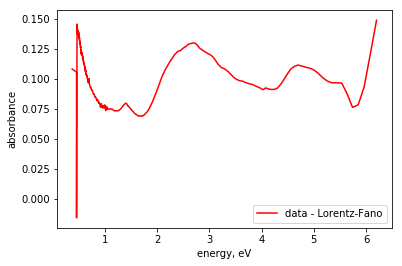

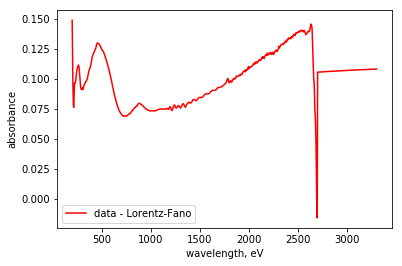

In [50]:
DLF=plt.plot(x, dataOCP['data-LF'], color='red', label='data - Lorentz-Fano')
plt.xlabel('energy, eV')
plt.ylabel('absorbance')
plt.legend()

plt.show()

DLF=plt.plot(u, dataOCP['data-LF'], color='red', label='data - Lorentz-Fano')
plt.xlabel('wavelength, eV')
plt.ylabel('absorbance')
plt.legend()

plt.show()

In [52]:
filename=dirname+'/'+name
dataOCP.to_csv(filename, sep=';')

In [54]:
file_parameters=open(filename+'parameters.txt', 'w+')
for k in range(0,len(LFopt)):
    file_parameters.write(str(LFopt[k])+'  ')
file_parameters.close()